# O Problema do Caxeiro Viajante

* PET - Física
* Petiano: Wallysson Pereira da Silva
* Data: **/**/2025

## Importando bibliotecas

$\quad$ O presente `Notebook` tem como objetivo introduzir o Problema do Caxeiro Viajante (TSP - Travelling Saleman Problem), junto com a apresentação de 3 método diferentes para a resolução do mesmo, sendo eles: O Método do Vizinho Mais Proximo 

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from random import random, randrange
from vpython import rate
import matplotlib.animation as animation
from IPython.display import Image, display


## Informações sobre as bibliotecas

In [25]:
%load_ext version_information
%version_information Matplotlib, Numpy

Software versions
Python 3.13.0 64bit [MSC v.1941 64 bit (AMD64)]
IPython 8.29.0
OS Windows 11 10.0.26100 SP0
Matplotlib 3.9.2
Numpy 2.1.3
Sun Apr 27 04:41:07 2025 Hora oficial do Brasil

## Introdução

$\quad$ O Problema do Caxeiro Viajante é um clássico problema de otimização da matemática. Classificado como NP-hard, não há solução absoluta que retorna a melhor solução para ese problema em tempo polinomial. 

In [26]:
N = 15
L = 100

np.random.seed(2)  # Para reprodutibilidade
cidades = np.random.rand(N, 2) * 100  # Coordenadas entre 0 e 100

cidades_NN = cidades.copy()
cidades_SA = cidades.copy()
cidades_SOM = cidades.copy()

## Nearest Neighbor

$\quad$ Esse é o método mais básico, mas que naturalmente também tem uma eficiência limitada. A lógica é simpleS: escolhemos uma cidades para sair, e a partir dela calculamos qual cidades é a mais próxima e viajamos até ela. Chegando nessa outra cidade, repetimos o processo, com o adendo de que excluimos a cidades anterior do conjuntos de cidades possíveis, do contrário ficaríamos indo e voltando ente duas cidades.

Ordem das cidades visitadas: [0, 11, 10, 2, 4, 14, 6, 12, 3, 7, 1, 5, 8, 9, 13, 0]
Distância total percorrida: 332.02


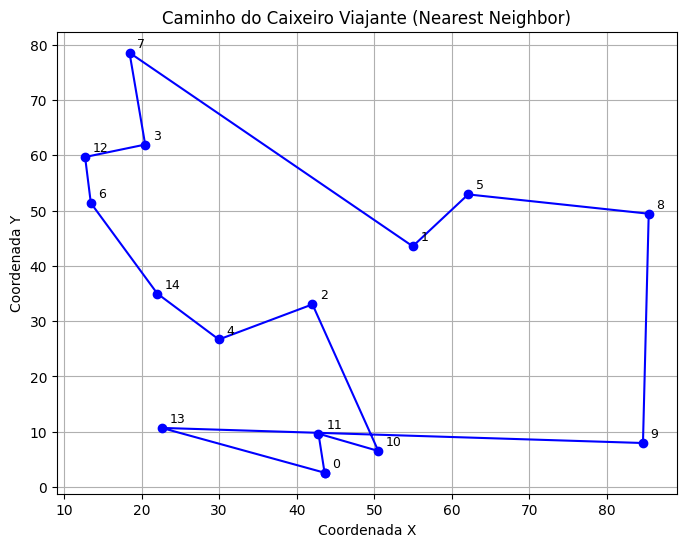

In [27]:
def nearest_neighbor(cidades_NN):
    n = cidades_NN.shape[0]
    visited = [0]  # Começa na cidade 0
    total_distance = 0.0

    while len(visited) < n:
        current_city = visited[-1]
        unvisited = [i for i in range(n) if i not in visited]
        distances = [np.linalg.norm(cidades_NN[current_city] - cidades_NN[i]) for i in unvisited]
        nearest = unvisited[np.argmin(distances)]
        visited.append(nearest)
        total_distance += min(distances)

    # Voltar à cidade inicial
    total_distance += np.linalg.norm(cidades_NN[visited[-1]] - cidades_NN[visited[0]])
    visited.append(visited[0])

    return visited, total_distance

# Resolver o problema
path, total_distance = nearest_neighbor(cidades_NN)

print("Ordem das cidades visitadas:", path)
print(f"Distância total percorrida: {total_distance:.2f}")

# Plotar o caminho
plt.figure(figsize=(8, 6))
plt.plot(cidades_NN[path, 0], cidades_NN[path, 1], 'o-', color='blue')
plt.title('Caminho do Caixeiro Viajante (Nearest Neighbor)')
for i, (x, y) in enumerate(cidades_NN):
    plt.text(x + 1, y + 1, str(i), fontsize=9)
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.grid(True)
plt.show()

## Simulated Annealling


$\quad$ O atual método tem uma sofisticação bem mais considerável, justamente por ser um método baseado em simulação de Monte Carlo. 

$\quad$ Tendo sua base no processo de resfriamento de um sólido, o primeiro passo no méotod Simulated Annealing é estabelecer uma trajetória inicial, que no nosso caso será: sair do elemento **r[0]**, passar pelo elemento **r[1]**, depopis pelo **r[2]**, até o elemento **r[N-1]**. Tal caminho terá uma distância total percorrida associada. Após calcular e armazenar essa distância, nós realizaremos uma comutação entre dois elementos aleatórios do vetor de cidades, cujo alteração resuatará numa nmova distância total percorrida. Nesse ponto, realizaremos uma condicional, onde: caso a nova distância seja menor, aceitaremos ela imediatamente; caso a nova distãncia seja maior, nós aceitaremos ela com a probabilidade de Boltzzman 

$$P(\Delta D) = e^{\frac{-\Delta D}{T}}.$$

Essa última condição nos dá uma garantia a mais de que não ficaremos preso em um mínimo local, fato que poderia facilmente acontecer caso sempre rejeitásemos trajetórias que aumentam a distãncia total.

$\quad$ O vetor de cidades (**cidades_NN**) utilizados anteriormente tem com elementos todas as cidades, começando pela cidade inicial **cidades_NN[0]** até a cidade final **cidades_NN[N-1]**. No entendo, para a formulação da solução utilizando Simulated Anneling, é interessante adicionar a cidade inicial novamente, no final do vetor. A explicação é simples: como queremos realizar um percurso fechado (retornando à cidade inicial), e estamos consideraremos a distância total percorrida passando por cada cidades vizinha no vetor, precisamos que a última cidade seja ligada à primeira cidade. Assim: 

In [28]:
aux = cidades_SA.copy()
cidades_SA = np.zeros([N+1,2], float)
for i in range(N):
    cidades_SA[i] = aux[i]
cidades_SA[N] = cidades_SA[0]

$\quad$ Para cada para de cidades, teremos que calcular a distância euclidiana entre elas. Assim, vamos definir uma função que calcula essa distância entre duas cidades, justamente com umaa função que, dado o vetor com todas as cidades, calcula a distância total seguindo o caminho anteriomente definido (seguindo a ordem natural do vetor).

In [29]:
def mag(x):
    return np.sqrt(x[0]**2+x[1]**2)

def distance(r):
    s = 0.0
    for i in range(N):
        dist = r[i+1]-r[i]
        s+=mag(dist)
    return(s)

$\quad$ Assim já podemos definir o corpo do códigoo em si, a função que vai receber o vetor com a trajetória inicial, e retornar uma trajetória otimizada.


In [30]:
def evoluir(cidades_SA, N, L, Tmin, tau):
    Tmax = 10.0

    t = 0
    T = Tmax
    quadros_SA = [cidades_SA.copy()]
    distancias = [distance(cidades_SA)]
    
    D = distance(cidades_SA)
    o = 0
    while(T>Tmin):
        t+=1
        T = Tmax*np.exp(-t/tau)

        c1, c2 = randrange(1,N),randrange(1,N)
        cidades_SA[[c1, c2]] = cidades_SA[[c2, c1]]
        Dnew = distance(cidades_SA)
        dDist = Dnew-D
        if (random()<np.exp(-dDist/T)):
            D = Dnew
            if o%10 == 0:
                quadros_SA.append(cidades_SA.copy())
        else:
            cidades_SA[[c1, c2]] = cidades_SA[[c2, c1]]
        distancias.append(D)    

        o+=1

    return cidades_SA, quadros_SA, distancias

$\quad$ Definida a função, podemos fornecer a condição inicial anteriormente definida e obter o caminho otimizado, passando como argumento os devidos parâmetros.

In [31]:
cidades_SA, quadros_SA, distancias = evoluir(cidades_SA, N, L, 1, 1e4)

$\quad$ Print da trajetória inicial (aleatoria) e a final (depois da otimização), junto com um gráfico da convergência do método:

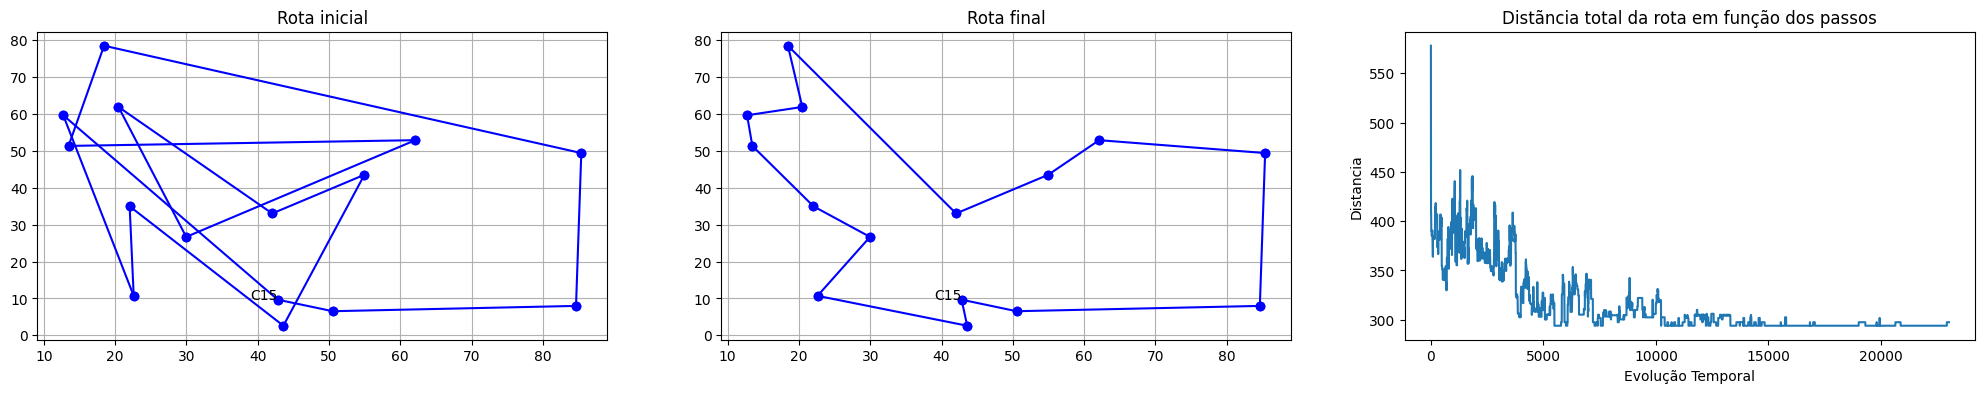

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(25, 4))  # 1 linha, 3 colunas

r_inicial = quadros_SA[0]
r_final = quadros_SA[-1]

for i in range(N-1):
        x1,y1 = r_inicial[i,0],r_inicial[i,1]
        x2,y2 = r_inicial[i+1,0],r_inicial[i+1,1]
        axes[0].plot([x1, x2], [y1, y2], 'bo-')
        axes[0].plot(x1, y1, f'C{i + 1}')
    
        x1,y1 = r_final[i,0],r_final[i,1]
        x2,y2 = r_final[i+1,0],r_final[i+1,1]
        axes[1].plot([x1, x2], [y1, y2], 'bo-')
        axes[1].plot(x1, y1, f'C{i + 1}')

x1, y1 = r_inicial[N-1,0], r_inicial[N-1,1]
x2, y2 = r_inicial[0,0], r_inicial[0,1]
axes[0].plot([x1, x2], [y1, y2], 'bo-')
axes[0].text(*cidades_SA[N-1], f'C{N}', fontsize=10, ha='right')
axes[0].grid(True)
axes[0].set_title("Rota inicial")

x1, y1 = r_final[N-1,0], r_final[N-1,1]
x2, y2 = r_final[0,0], r_final[0,1]
axes[1].plot([x1, x2], [y1, y2], 'bo-')
axes[1].text(*cidades_SA[N-1], f'C{N}', fontsize=10, ha='right')
axes[1].grid(True)
axes[1].set_title("Rota final")

axes[2].plot(distancias)
axes[2].set_xlabel("Evolução Temporal")
axes[2].set_ylabel("Distancia")
axes[2].set_title("Distãncia total da rota em função dos passos")

plt.show()

$\quad$ O seguinte código é dedicado apenas à definição de uma animação, onde podemos analisar visualmente a convergência da trajetória.

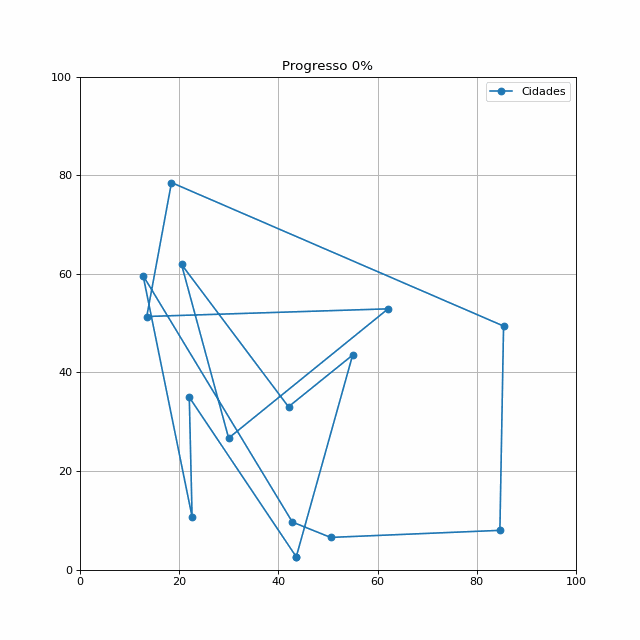

In [33]:
fig, ax = plt.subplots(figsize=(8,8))

def atualizar_SA(i):
    ax.clear()
    cidades_quadro = quadros_SA[i]
    ax.plot(cidades_quadro[:, 0], cidades_quadro[:, 1], 'o-', label='Cidades')
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_title(f'Progresso {(i/len(quadros_SA)*100):.0f}%')
    ax.legend()
    ax.grid(True)

ani = animation.FuncAnimation(fig, atualizar_SA, np.arange(len(quadros_SA)), interval=50)

ani.save('simulated_annealing.gif', writer='pillow', dpi=80)
plt.close(fig)
display(Image(filename='simulated_annealing.gif'))

## Self-Organizing Maps

In [34]:
# Parâmetros
num_cidades = 15
num_neuronios = 8 * num_cidades  # mais neurônios que cidades
num_epocas = 1000
alpha_inicial = 0.8
raio_inicial = num_neuronios // 2
decaimento_constante = num_epocas / np.log(raio_inicial)


# Inicializar neurônios em um círculo
theta = np.linspace(0, 2*np.pi, num_neuronios, endpoint=False)
neuronios = np.column_stack((L*np.cos(theta), L*np.sin(theta))) * 0.5 + L//2  # centralizado no [0,1]x[0,1]


# Função de distância euclidiana
def distancia(a, b):
    return np.linalg.norm(a - b, axis=1)


quadros_SOM = [neuronios.copy()]
# Treinamento SOM
for epoca in range(num_epocas):
    cidade_idx = np.random.randint(num_cidades)
    cidade = cidades_SOM[cidade_idx]

    # Encontrar neurônio vencedor
    distancias = distancia(neuronios, cidade)
    vencedor_idx = np.argmin(distancias)

    # Decaimento dos parâmetros
    alpha = alpha_inicial * np.exp(-epoca / num_epocas)
    raio = raio_inicial * np.exp(-epoca / decaimento_constante)

    # Atualizar neurônios
    for i in range(num_neuronios):
        # distância circular entre os neurônios (SOM é um anel)
        delta = min(abs(i - vencedor_idx), num_neuronios - abs(i - vencedor_idx))
        if delta < raio:
            influencia = np.exp(-delta**2 / (2 * (raio**2)))
            neuronios[i] += alpha * influencia * (cidade - neuronios[i])
    
    if epoca % 10 == 0:  # salva a cada 10 épocas (pode ajustar esse valor)
        quadros_SOM.append(neuronios.copy())




# Obter ordem final das cidades
ordem = []
for cidade in cidades:
    distancias = distancia(neuronios, cidade)
    idx = np.argmin(distancias)
    ordem.append((idx, cidade))
ordem.sort()
caminho = np.array([cidade for _, cidade in ordem])




Vizualização da solução

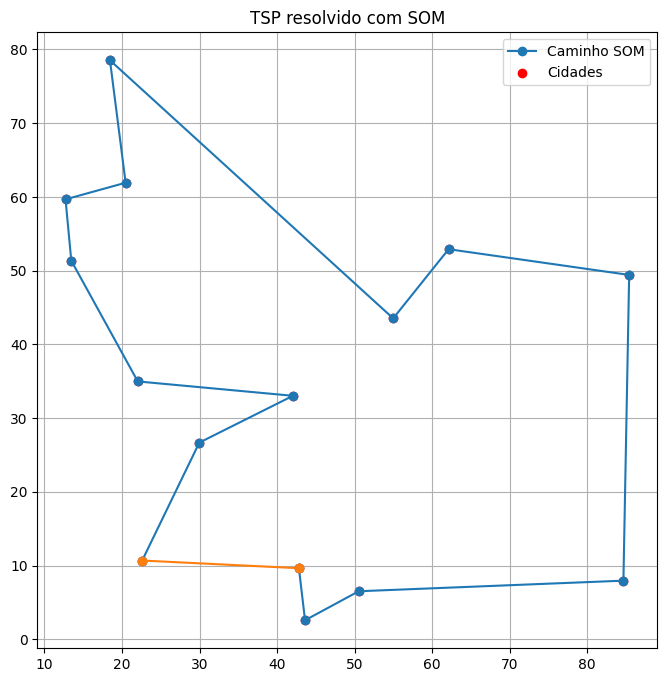

In [35]:
plt.figure(figsize=(8, 8))
plt.plot(caminho[:, 0], caminho[:, 1], 'o-', label='Caminho SOM')
plt.plot([caminho[-1, 0], caminho[0, 0]], [caminho[-1, 1], caminho[0, 1]], 'o-')
plt.scatter(cidades_SOM[:, 0], cidades_SOM[:, 1], c='red', label='Cidades')
plt.title('TSP resolvido com SOM')
plt.legend()
plt.grid(True)
plt.show()

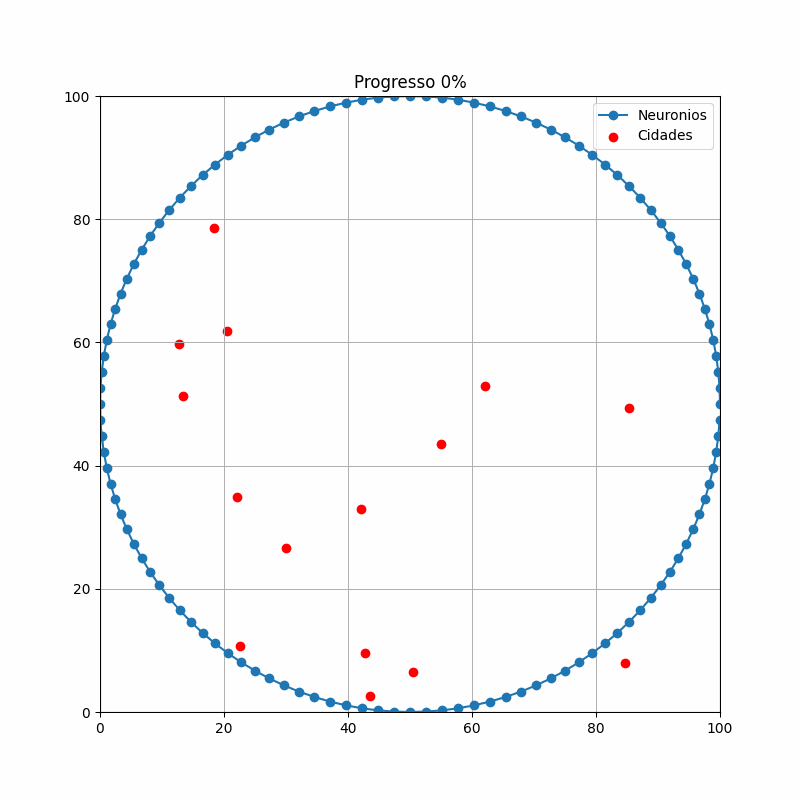

In [36]:
fig, ax = plt.subplots(figsize=(8,8))

def atualizar(frame_idx):
    ax.clear()
    neuronios_frame = quadros_SOM[frame_idx]
    ax.plot(neuronios_frame[:, 0], neuronios_frame[:, 1], 'o-', label='Neuronios')
    ax.scatter(cidades[:, 0], cidades[:, 1], c='red', label='Cidades')
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_title(f'Progresso {(frame_idx/len(quadros_SOM)*100):.0f}%')
    ax.legend()
    ax.grid(True)

ani = animation.FuncAnimation(fig, atualizar, frames=len(quadros_SOM), interval=100)

ani.save('self_organizing_maps.gif', writer='pillow')
plt.close(fig)
display(Image(filename='self_organizing_maps.gif'))
